In [1]:
import sys
sys.path.append('..')

In [32]:
import torch
import torchvision
import stad
import cv2
import numpy as np

from pathlib import Path
from torch import nn
from torch.utils.data import DataLoader
from stad.datasets.MVTecDataset import MVTecDataset

In [22]:
Y = {}
Y['train_teacher_dir'] = Path('/dgx/inoue/data/bottle/train_teacher')
Y['train_student_dir'] = Path('/dgx/inoue/data/bottle/train_student/good')
Y['batch_size'] = 1
Y['epochs'] = 1000
Y['device'] = 'cuda:0'

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2

train_augs = [albu.HorizontalFlip(p=0.5),
              albu.RandomCrop(height=128, width=128, always_apply=True, p=1)]
train_augs = albu.Compose(train_augs)    

preprocessing = [albu.Normalize(always_apply=True, p=1),
                 ToTensorV2()]
preprocessing = albu.Compose(preprocessing)

In [6]:
mvtec = MVTecDataset(img_dir=Y['train_teacher_dir'],
                     augmentations=train_augs,
                     preprocessing=preprocessing)

teacher_train_loader = DataLoader(dataset=mvtec,
                                  batch_size=Y['batch_size'],
                                  shuffle=True)

In [7]:
model = AutoEncoder().to(Y['device'])

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [9]:
for epoch in range(Y['epochs']):
    for img in teacher_train_loader:
        img = img.to(Y['device'])
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch%100 == 0:    
        print(f"epoch [{epoch}/{Y['epochs']}]")

epoch [0/1000]
epoch [100/1000]
epoch [200/1000]
epoch [300/1000]
epoch [400/1000]
epoch [500/1000]
epoch [600/1000]
epoch [700/1000]
epoch [800/1000]
epoch [900/1000]


In [54]:
for img in teacher_train_loader:
    img = img.to(Y['device'])
    output = model(img)
    break

In [55]:
img = img.squeeze().transpose(0, 2)
img = img.cpu().detach().numpy()
output = output.squeeze().transpose(0, 2)
output = output.cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


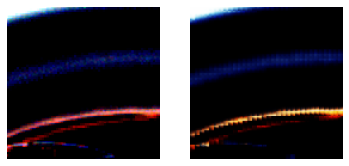

In [62]:
plt.subplot(121)
plt.imshow(img)
plt.axis('off')

plt.subplot(122)
plt.imshow(output)
plt.axis('off')

plt.show()

In [14]:
teacher = model.encoder

student = AutoEncoder().encoder
student = student.to(Y['device'])

In [23]:
mvtec = MVTecDataset(img_dir=Y['train_student_dir'],
                     augmentations=train_augs,
                     preprocessing=preprocessing)

teacher_train_loader = DataLoader(dataset=mvtec,
                                  batch_size=Y['batch_size'],
                                  shuffle=True)

In [24]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

In [26]:
teacher.eval()

for epoch in range(Y['epochs']):
    for i, img in enumerate(teacher_train_loader):
         
        img = img.to(Y['device'])
        with torch.no_grad():
            surrogate_label = teacher(img)
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch%100 == 0:    
        print(f"epoch [{epoch}/{Y['epochs']}]")

epoch [0/1000]
epoch [100/1000]
epoch [200/1000]
epoch [300/1000]
epoch [400/1000]
epoch [500/1000]
epoch [600/1000]
epoch [700/1000]
epoch [800/1000]
epoch [900/1000]


In [27]:
from albumentations.pytorch import ToTensorV2

preprocessing = [albu.Normalize(always_apply=True, p=1),
                 ToTensorV2()]
preprocessing = albu.Compose(preprocessing)

In [30]:
img_path = '/dgx/shared/momo/Data/MVTEc/bottle/test/broken_small/000.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [34]:
anomaly_map = np.zeros((900, 900))

teacher.eval()
student.eval()
for i in range(64, 900-64):
    for j in range(64, 900-64):
        patch = img[i-64:i+64, j-64:j+64]
        sample = preprocessing(image=patch)
        patch = sample['image']
        patch = patch.unsqueeze(0)
        patch = patch.to(Y['device'])
        
        surrogate_label = teacher(patch)
        pred = student(patch)
        loss = criterion(pred, surrogate_label)
        anomaly_map[i, j] = loss.item()

    if i%100 == 0:
        print(i)

100
200
300
400
500
600
700
800


In [35]:
img = cv2.imread('/dgx/shared/momo/Data/MVTEc/bottle/test/broken_small/000.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread('/dgx/shared/momo/Data/MVTEc/bottle/ground_truth/broken_small/000_mask.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

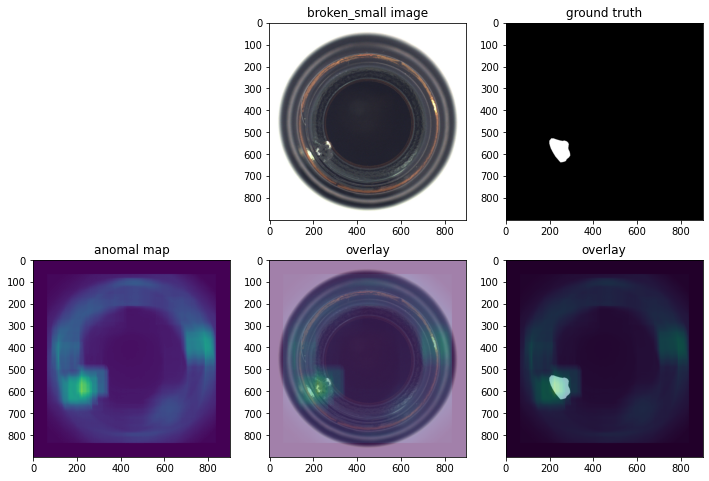

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(232)
plt.imshow(img)
plt.title('broken_small image')

plt.subplot(233)
plt.imshow(mask)
plt.title('ground truth')

plt.subplot(234)
plt.imshow(anomaly_map)
plt.title('anomal map')

plt.subplot(235)
plt.imshow(img)
plt.imshow(anomaly_map, alpha=0.5)
plt.title('overlay')

plt.subplot(236)
plt.imshow(anomaly_map)
plt.imshow(mask, alpha=0.5)
plt.title('overlay')

plt.show()